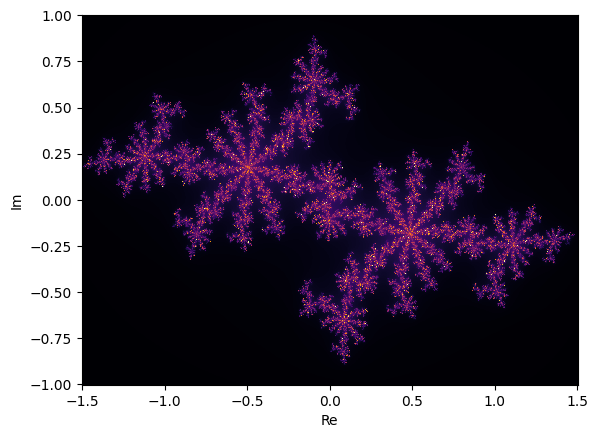

Area of the convex hull: 2.934798034464232


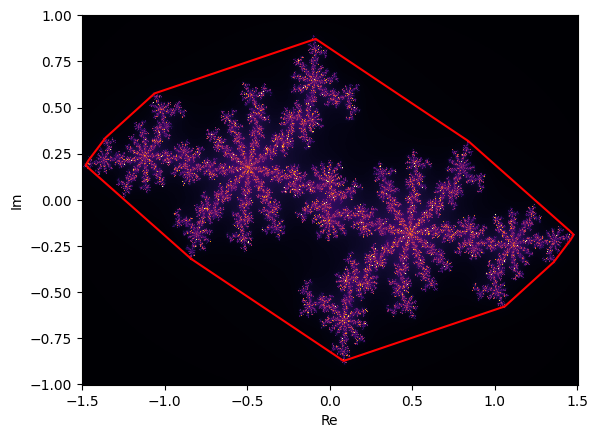

Estimated area using boundary detection: 1.3032


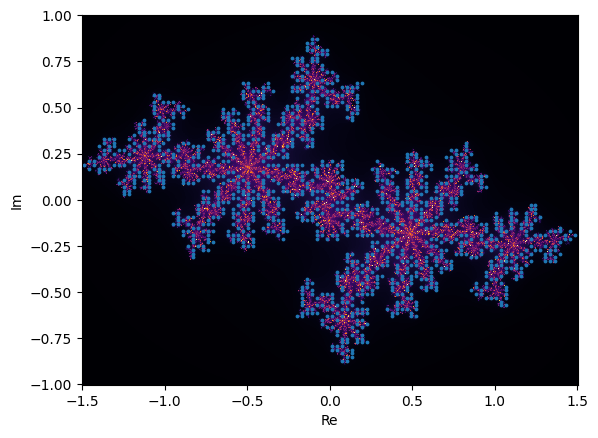

Estimated Fractal Dimension: 1.9049374376427683


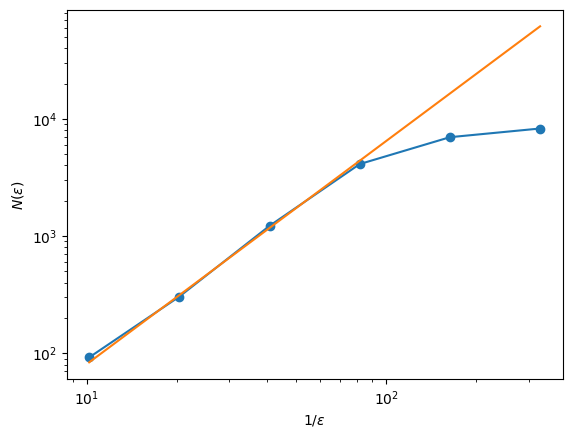

In [ ]:
#!/usr/bin/env python

from numpy import linspace, meshgrid, vectorize, where, array, roll, sum, log, sqrt, exp
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit

# a: Julia Set Computation
def julia_set_escape_time(initial_z, constant_c, max_iterations, escape_radius):
    """Compute the escape time for each point in the Julia set."""
    z = initial_z
    for iteration in range(max_iterations):
        if abs(z) > escape_radius:
            return iteration
        z = z**2 + constant_c
    return max_iterations

julia_set_escape_time = vectorize(julia_set_escape_time)

# Define grid for Julia set
real_min, real_max = -1.5, 1.5
imag_min, imag_max = -1, 1
real_resolution = 800
imag_resolution = 800
real_axis, imag_axis = meshgrid(linspace(real_min, real_max, real_resolution), 
                                linspace(imag_min, imag_max, imag_resolution))
initial_complex_values = real_axis + 1j * imag_axis
constant_c = -0.7 + 0.356j
max_iterations = 256
escape_radius = 2
julia_pixels = julia_set_escape_time(initial_complex_values, constant_c, max_iterations, escape_radius)

plt.pcolor(real_axis, imag_axis, julia_pixels, cmap='inferno')
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()

# b: Convex Hull and Area Calculation
def draw_convex_hull(polygon_points):
    """Draw convex hull around boundary points."""
    xs, ys = zip(*polygon_points)
    xs += xs[:1]
    ys += ys[:1]
    plt.plot(xs, ys, 'r-')

def polygon_area(vertices):
    """Calculate area of a polygon given its vertices."""
    xs, ys = array(vertices).T
    return 0.5 * sum(roll(xs, 1) * ys - xs * roll(ys, 1))

julia_threshold = max_iterations / 2
julia_boolean_pixels = julia_pixels > julia_threshold
boundary_points = list(zip(real_axis[julia_boolean_pixels], imag_axis[julia_boolean_pixels]))
convex_hull_vertices = [boundary_points[v] for v in ConvexHull(boundary_points).vertices]

print(f'Area of the convex hull: {polygon_area(convex_hull_vertices)}')

draw_convex_hull(convex_hull_vertices)
plt.pcolor(real_axis, imag_axis, julia_pixels, cmap='inferno')
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()

# c: Boundary and Scaling Analysis
def downsample(array_data, factor):
    """Downsample a 2D array by a given factor."""
    rows, cols = array_data.shape
    if array_data.dtype == bool:
        return array_data.reshape(rows // factor, factor, cols // factor, factor).max(axis=(1, 3))
    elif array_data.dtype == float:
        return array_data.reshape(rows // factor, factor, cols // factor, factor).mean(axis=(1, 3))

def detect_boundary(bool_array):
    """Detect boundary pixels in a boolean array."""
    bool_array = bool_array.astype(bool)  # Ensure input is boolean
    up_shift = roll(bool_array, 1, axis=0)
    down_shift = roll(bool_array, -1, axis=0)
    left_shift = roll(bool_array, 1, axis=1)
    right_shift = roll(bool_array, -1, axis=1)
    return bool_array & ~(up_shift & down_shift & left_shift & right_shift)

# Downsampling and boundary detection
scaling_factor = 8
scaled_julia_boolean_pixels = downsample(julia_boolean_pixels, scaling_factor).astype(bool)
scaled_real_axis = downsample(real_axis, scaling_factor)
scaled_imag_axis = downsample(imag_axis, scaling_factor)
boundary_mask = detect_boundary(scaled_julia_boolean_pixels)

# Estimate area using boundary detection
area_estimate = np.sum(scaled_julia_boolean_pixels) * (real_max - real_min) * (imag_max - imag_min) / ((real_resolution / scaling_factor) * (imag_resolution / scaling_factor))
print(f'Estimated area using boundary detection: {area_estimate}')

plt.pcolor(real_axis, imag_axis, julia_pixels, cmap='inferno')
plt.xlabel('Re')
plt.ylabel('Im')
plt.scatter(scaled_real_axis[boundary_mask], scaled_imag_axis[boundary_mask], s=3)
plt.show()

# d: Fractal Dimension Estimation
scaling_factors = np.array([32, 16, 8, 4, 2, 1])
box_areas = (real_max - real_min) * (imag_max - imag_min) / ((real_resolution / scaling_factors) * (imag_resolution / scaling_factors))
box_counts = np.array([np.sum(detect_boundary(downsample(julia_boolean_pixels, factor).astype(bool))) for factor in scaling_factors])
inverse_epsilon = 1 / np.sqrt(box_areas)

plt.plot(inverse_epsilon, box_counts, 'o-')
plt.xlabel(r'$1/\epsilon$')
plt.ylabel(r'$N(\epsilon)$')
plt.xscale('log')
plt.yscale('log')

# Fit a scaling relation for fractal dimension
def scaling_relation(x, coefficient):
    return coefficient * x

optimal_params, _ = curve_fit(scaling_relation, log(inverse_epsilon)[:4], log(box_counts)[:4])
print(f'Estimated Fractal Dimension: {optimal_params[0]}')

plt.plot(inverse_epsilon, exp(scaling_relation(log(inverse_epsilon), *optimal_params)))
plt.show()